<a href="https://colab.research.google.com/github/alejandraberbesi/Notebooks_ML/blob/main/2_Arboles_Decision_%2B_Random_Forest%2B_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje supervisado para problemas de clasificacion

**Material complementario**: https://www.aprendemachinelearning.com/arbol-de-decision-en-python-clasificacion-y-prediccion/


Los arboles de decisión son representaciones gráficas de posibles soluciones a una decisión basadas en ciertas condiciones, es uno de los algoritmos de aprendizaje supervisado más utilizados en machine learning y pueden realizar tareas de clasificación o regresión.

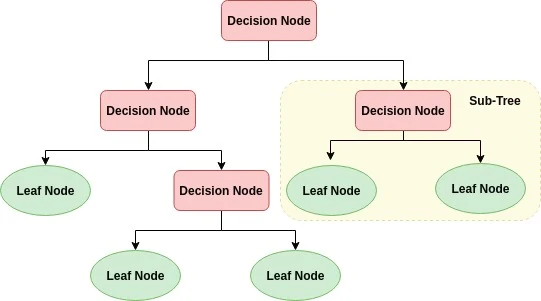

En este notebook vamos a utilizar la siguiente fuente de datos: https://www.kaggle.com/datasets/yasserh/titanic-dataset

**Features del dataset**:

* PassengerId: Número de identificación del pasajero.
* Survived: Indicador binario que especifica si el pasajero sobrevivió (1) o no (0).
* Pclass: Clase de ticket del pasajero (1, 2 o 3).
* Name: Nombre del pasajero.
* Sex: Género del pasajero (male o female).
* Age: Edad del pasajero.
* SibSp: Número de hermanos/cónyuges a bordo.
* Parch: Número de padres/hijos a bordo.
* Ticket: Número de ticket.
* Fare: Tarifa del pasajero.
* Cabin: Número de cabina.
* Embarked: Puerto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton).

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier  #arbol de decision
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import tree

In [ ]:
from google.colab import drive #para conectar con google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/superprof/Python/Machine learning/Datasets/Titanic-Dataset.csv',
               index_col=0 #para transformar passenger id en indice
               )
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
df[df.duplicated()] #no hay filas duplicadas

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [ ]:
#porcentaje de valores nulos para cada columna

(df.isna().sum()*100.00)/len(df)

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

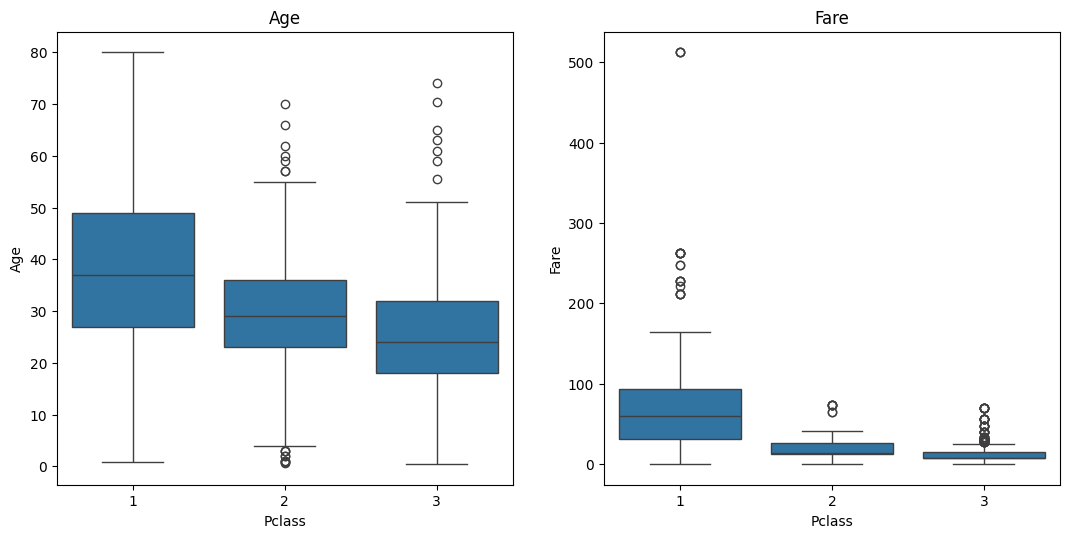

In [ ]:
#visualizaciones 1

l=['Age',  'Fare']
plt.figure(figsize=(20,20))

for i in range(len(l)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df.Pclass,y=df[l[i]])
    plt.title(l[i])

plt.show()

In [ ]:
def remove_outliers_by_class(data, column_name):

    # Calcular cuartiles para cada 'Pclass'
    quartiles_by_class = data.groupby('Pclass')[column_name].quantile([0.25, 0.75])

    # Calcular rango intercuartilico (IQR) para cada 'Pclass'
    iqr_by_class = quartiles_by_class.groupby('Pclass').diff().fillna(0)

    # definir los bigotes
    lower_whisker = quartiles_by_class - 1.5 * iqr_by_class
    upper_whisker = quartiles_by_class + 1.5 * iqr_by_class

    # aplicar el filtro para remover valores debajo o por encima de los bigotes para cada clase
    new_data = data.groupby('Pclass').apply(
        lambda x: x[(x[column_name] >= lower_whisker.loc[x['Pclass']].values[0]) &
                    (x[column_name] <= upper_whisker.loc[x['Pclass']].values[1])]
    )

    # Reset the index after grouping
    new_data.reset_index(drop=True, inplace=True)

    return new_data


In [ ]:
df2 = remove_outliers_by_class(df, 'Fare')
df2 = remove_outliers_by_class(df2, 'Age')

In [ ]:
#cuantas filas nos quedamos?

1-(len(df2)/len(df))

0.5723905723905724

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  381 non-null    int64  
 1   Pclass    381 non-null    int64  
 2   Name      381 non-null    object 
 3   Sex       381 non-null    object 
 4   Age       381 non-null    float64
 5   SibSp     381 non-null    int64  
 6   Parch     381 non-null    int64  
 7   Ticket    381 non-null    object 
 8   Fare      381 non-null    float64
 9   Cabin     92 non-null     object 
 10  Embarked  379 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 32.9+ KB


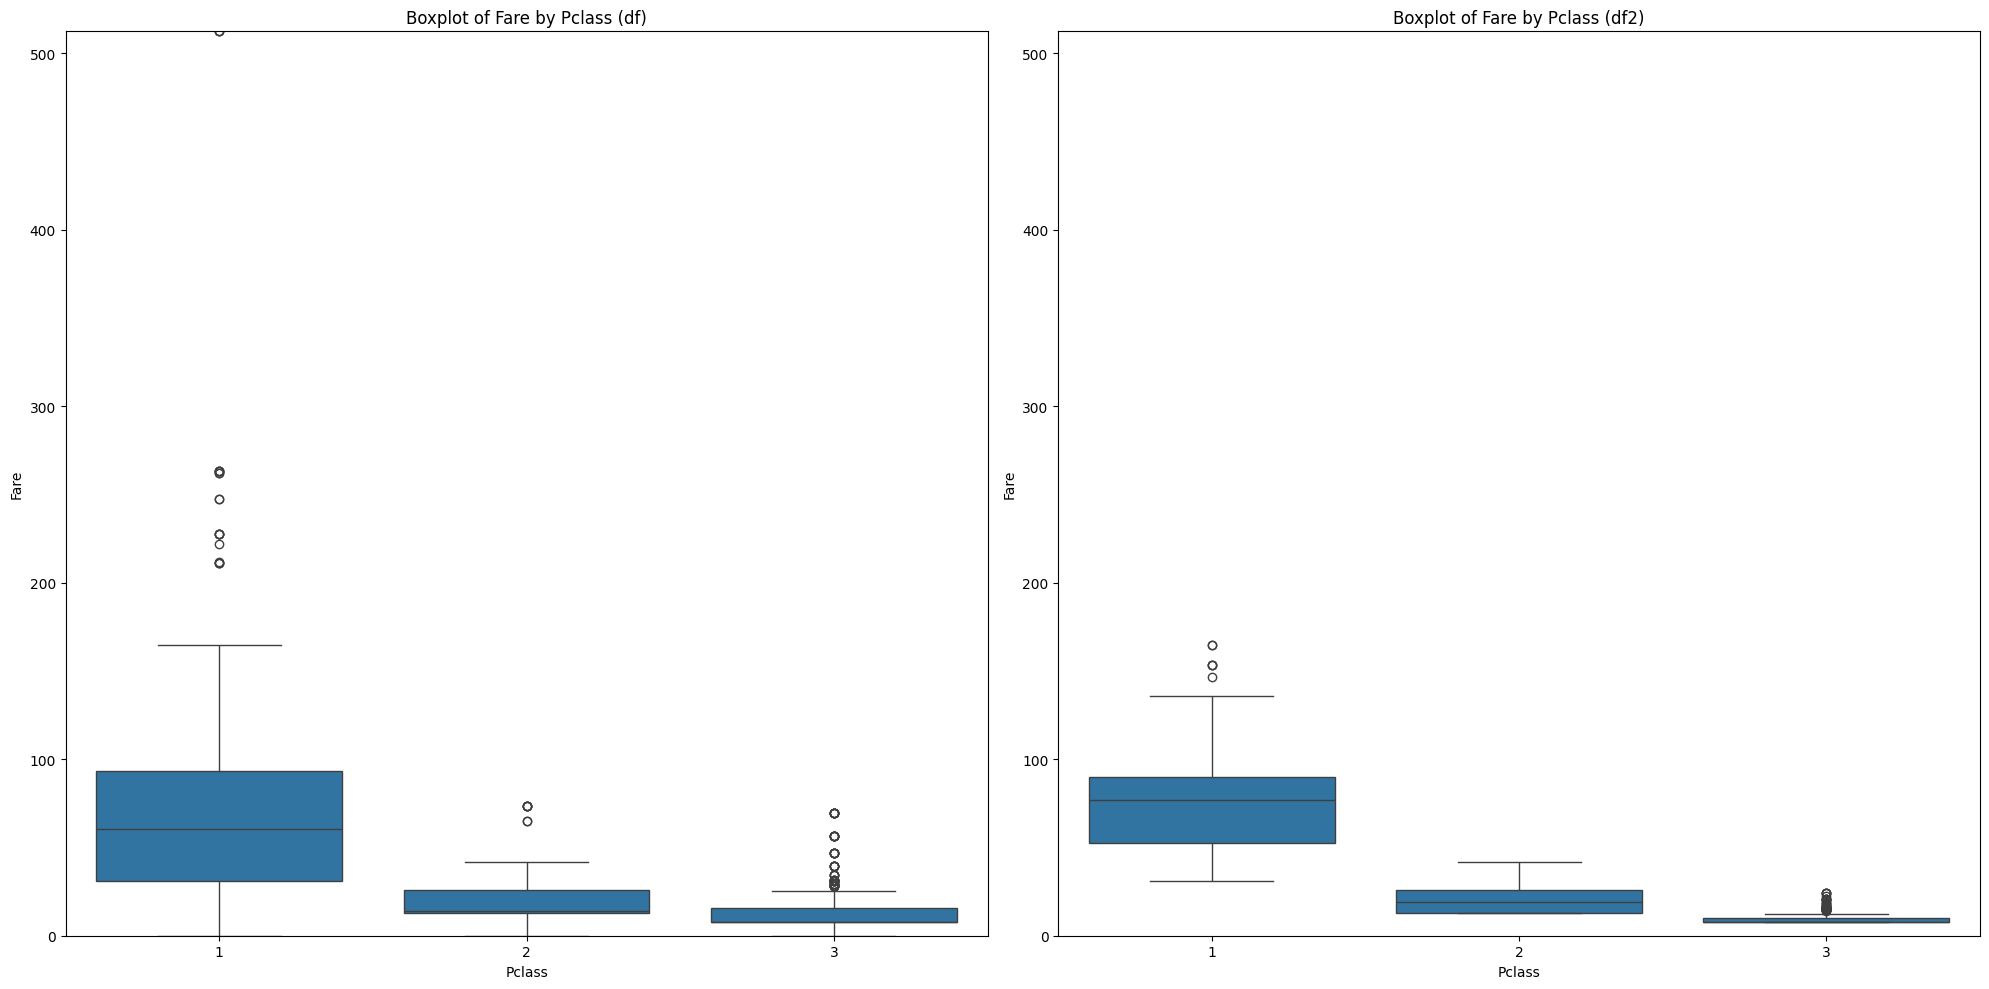

In [ ]:
#visualizaciones 2

# limites de los ejes y
y_min = min(df['Fare'].min(), df2['Fare'].min())
y_max = max(df['Fare'].max(), df2['Fare'].max())

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# diagrama de caja para primer dataframe (antes de sacar outliers)
sns.boxplot(x=df.Pclass, y=df['Fare'], ax=axs[0])
axs[0].set_title('Boxplot of Fare by Pclass (df)')
axs[0].set_xlabel('Pclass')
axs[0].set_ylabel('Fare')
axs[0].set_ylim(y_min, y_max)

# diagrama de caja para segundo dataframe (despues de sacar outliers)
sns.boxplot(x=df2.Pclass, y=df2['Fare'], ax=axs[1])
axs[1].set_title('Boxplot of Fare by Pclass (df2)')
axs[1].set_xlabel('Pclass')
axs[1].set_ylabel('Fare')
axs[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

**Valores nulos**

In [ ]:
#porcentaje de valores nulos para cada columna

(df2.isna().sum()*100.00)/len(df2)

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       75.853018
Embarked     0.524934
dtype: float64

In [ ]:
#cabin tiene demasiados valores nulos y por eso se eliminara la columna
df2 = df2.drop(columns=['Cabin'])

In [ ]:
#se van a eliminar filas con valores nulos de embarked, para no usar esa informacion porque no sabriamos que valores agregar a columna
df2 = df2.dropna(subset=['Embarked'])

In [ ]:
#porcentaje de valores nulos para cada columna

(df2.isna().sum()*100.00)/len(df2)

Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Embarked    0.0
dtype: float64

In [ ]:
#vamos a eliminar las columnas con muchos valores unicos de texto: 'Name' y 'Ticket'

df2 = df2.drop(columns=['Name', 'Ticket'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 0 to 380
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  379 non-null    int64  
 1   Pclass    379 non-null    int64  
 2   Sex       379 non-null    object 
 3   Age       379 non-null    float64
 4   SibSp     379 non-null    int64  
 5   Parch     379 non-null    int64  
 6   Fare      379 non-null    float64
 7   Embarked  379 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 26.6+ KB


In [ ]:
# Crear variables dummies para 'Pclass'
pclass_dummies = pd.get_dummies(df2['Pclass'], prefix='Pclass', drop_first=True)

# Crear variables dummies para 'Sex'
sex_dummies = pd.get_dummies(df2['Sex'], prefix='Sex', drop_first=True)

# Crear variables dummies para 'Embarked'
embarked_dummies = pd.get_dummies(df2['Embarked'], prefix='Embarked', drop_first=True)

# Concatenar las variables dummies al DataFrame original
df2 = pd.concat([df2, pclass_dummies, sex_dummies, embarked_dummies], axis=1)

# Eliminar las columnas originales
df2.drop(['Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)

# Ver las primeras filas del DataFrame modificado
df2.head()


,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,1,38.0,1,0,71.2833,False,False,False,False,False
1,1,35.0,1,0,53.1000,False,False,False,False,True
2,0,54.0,0,0,51.8625,False,False,True,False,True
3,1,28.0,0,0,35.5000,False,False,True,False,True
4,0,28.0,1,0,82.1708,False,False,True,False,False


In [ ]:
# Separar las características (X) y la variable objetivo (y)
X = df2.drop(columns=['Survived'])
y = df2['Survived']  # la variable objetivo que queremos predecir ('Survived').

# Diferentes metodos escalamiento

<font color='magenta'> **Método de Standard Scaler** </font>

A cada dato se le resta la media de la variable y el resultado se divide entre la desviacion estandar de la variable.

Formula:
 $ \displaystyle\frac{X - media}{desviacionEstandar}$

Al final, la idea es que la media de la distribucion escalada de cada variable quede alrededor de 0 y la desviacion estandar alrededor de 1.

In [ ]:
# Aplica el escalamiento solo a las columnas especificadas
columns_to_scale = ['Age', 'SibSp', 'Parch', 'Fare']

In [ ]:
#como se ven columnas antes
df2[columns_to_scale].describe()

,Age,SibSp,Parch,Fare
count,379.000000,379.000000,379.000000,379.000000
mean,33.866755,0.382586,0.253298,29.222932
std,10.635436,0.567005,0.599125,32.623945
min,19.000000,0.000000,0.000000,7.750000
25%,26.000000,0.000000,0.000000,8.050000
50%,31.000000,0.000000,0.000000,14.000000
75%,40.000000,1.000000,0.000000,31.660400
max,71.000000,3.000000,4.000000,164.866700


In [ ]:
scaler = StandardScaler()

X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# Muestra el conjunto de datos resultante
X.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0.389143,1.090343,-0.423339,1.290953,False,False,False,False,False
1,0.106695,1.090343,-0.423339,0.732855,False,False,False,False,True
2,1.895537,-0.675640,-0.423339,0.694873,False,False,True,False,True
3,-0.552353,-0.675640,-0.423339,0.192661,False,False,True,False,True
4,-0.552353,1.090343,-0.423339,1.625121,False,False,True,False,False


In [ ]:
#como se ven columnas despues, mean alrededor de 0 y std alrededor de 1
X[columns_to_scale].describe().round(3)

,Age,SibSp,Parch,Fare
count,379.000,379.000,379.000,379.000
mean,-0.000,0.000,-0.000,-0.000
std,1.001,1.001,1.001,1.001
min,-1.400,-0.676,-0.423,-0.659
25%,-0.741,-0.676,-0.423,-0.650
50%,-0.270,-0.676,-0.423,-0.467
75%,0.577,1.090,-0.423,0.075
max,3.496,4.622,6.262,4.163


<font color='magenta'> **Método de Normalizacion L2** </font>


**La idea la final es que para cada fila del dataframe escalado, si se elevara cada elemento al cuadrado y se sumara el resultado sea igual a 1.**

Formula: Divide cada dato del dataframe original entre el vector unitario de la FILA.

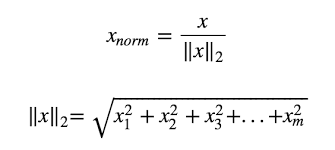

In [ ]:
from sklearn.preprocessing import Normalizer

scaler2 = Normalizer()

col_escaladas=scaler2.fit_transform(df2[columns_to_scale])

col_escaladas=pd.DataFrame(col_escaladas,columns=columns_to_scale)
col_escaladas.head()

,Age,SibSp,Parch,Fare
0,0.470381,0.012378,0.0,0.882377
1,0.550270,0.015722,0.0,0.834839
2,0.721237,0.000000,0.0,0.692688
3,0.619286,0.000000,0.0,0.785166
4,0.322521,0.011519,0.0,0.946492


In [ ]:
#demostracion para primera fila (indice 0)
#elevando cada dato al cuadrado y luego sumandolo, valor total debe ser igual o muy cercano a 1

col_escaladas['Age'][0]**2+col_escaladas['SibSp'][0]**2  \
+col_escaladas['Parch'][0]**2 + +col_escaladas['Fare'][0]**2

0.9999999999999999

In [ ]:
col_escaladas.describe().round(3)

,Age,SibSp,Parch,Fare
count,379.000,379.000,379.000,379.000
mean,0.809,0.008,0.005,0.501
std,0.199,0.014,0.015,0.234
min,0.185,0.000,0.000,0.150
25%,0.723,0.000,0.000,0.307
50%,0.901,0.000,0.000,0.434
75%,0.951,0.014,0.000,0.690
max,0.989,0.082,0.111,0.983


<font color='magenta'> **Método de MinMax** </font>

Esta técnica específica de escalado transforma los datos de tal manera que se ajustan a un rango específico, generalmente entre 0 y 1. Funciona restando el valor mínimo de la característica y luego dividiendo por el rango (la diferencia entre el valor máximo y el mínimo).

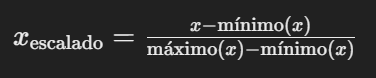

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler3 = MinMaxScaler()

col_escaladas2=scaler3.fit_transform(df2[columns_to_scale])


col_escaladas2=pd.DataFrame(col_escaladas2,columns=columns_to_scale)
col_escaladas2.describe()

,Age,SibSp,Parch,Fare
count,379.000000,379.000000,379.000000,379.000000
mean,0.285899,0.127529,0.063325,0.136669
std,0.204528,0.189002,0.149781,0.207641
min,0.000000,0.000000,0.000000,0.000000
25%,0.134615,0.000000,0.000000,0.001909
50%,0.230769,0.000000,0.000000,0.039779
75%,0.403846,0.333333,0.000000,0.152182
max,1.000000,1.000000,1.000000,1.000000


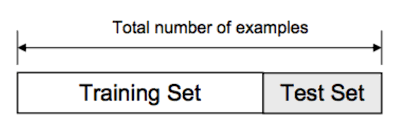

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

In [ ]:
clf = DecisionTreeClassifier(random_state=435,
                             max_depth=3) #maxima cantidad de niveles

clf.fit(X_train, y_train) #entrenamiento

DecisionTreeClassifier(max_depth=3, random_state=435)

-------------------------------------------

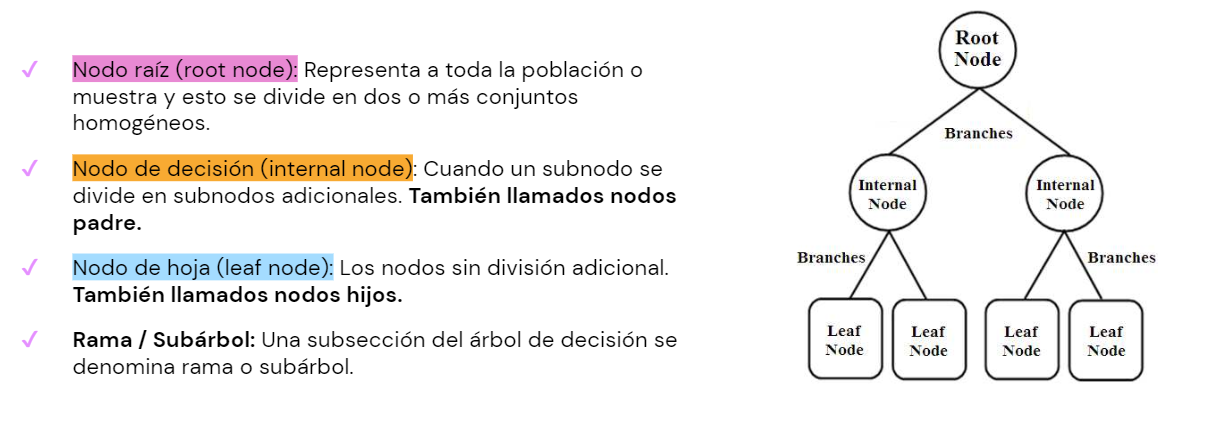

**Gini impurity:**

Cada división del árbol  de decisión es determinada siguiendo un criterio que mide la calidad de la división (de forma numérica).

El indice de gini es un valor entre 0 y 1, donde cero representa igualdad de clases perfecta y 1 representa desigualdad total.

**La idea detrás de la creación de cada rama es que se minimice el valor del gini impurity.**

Si la rama tiene un gini index mayor a 0, se siguen haciendo divisiones en el árbol hasta que alcance el 0 (que serían los nodos de hoja o leaf node).

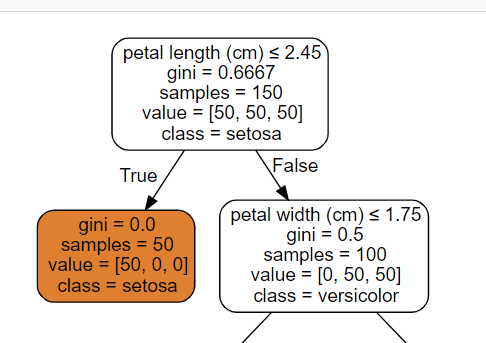

--------------

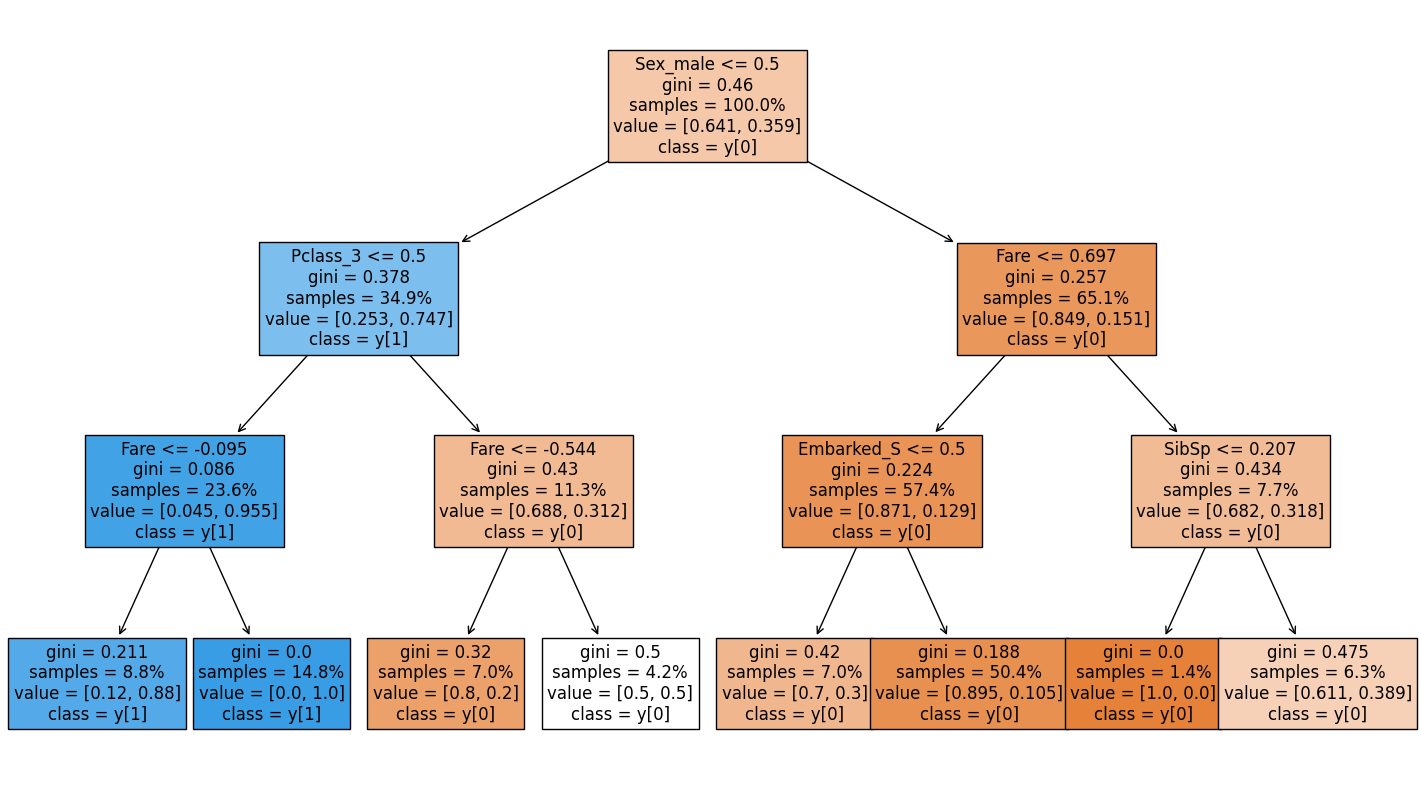

In [ ]:
# Graficando
fig = plt.figure(figsize=(18,10))
tree.plot_tree(clf,
               feature_names=X_train.columns,
               class_names=True,
               fontsize=12,
               proportion=True,
               filled=True
               )

plt.show()

#rama izquierda significa que cumple con requisito, rama derecha que no

In [ ]:
y_pred = clf.predict(X_test) #generando predicciones para categorias binarias

y_pred

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0])

In [ ]:
#clf.predict_proba(X_test) #los modelos tambien tienen resultados con la probabilidad asociada a cada clase

In [ ]:
X_test.head(1) #primera prediccion es para esta fila del X_test

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
357,1.330639,-0.67564,-0.423339,-0.655867,False,True,True,False,True


In [ ]:
df2.iloc[357,:] #en el dataset original (post tratamiento de valores atipicos) estos son los datos

Survived           1
Age             31.0
SibSp              0
Parch              0
Fare          8.6833
Pclass_2       False
Pclass_3        True
Sex_male       False
Embarked_Q     False
Embarked_S      True
Name: 359, dtype: object

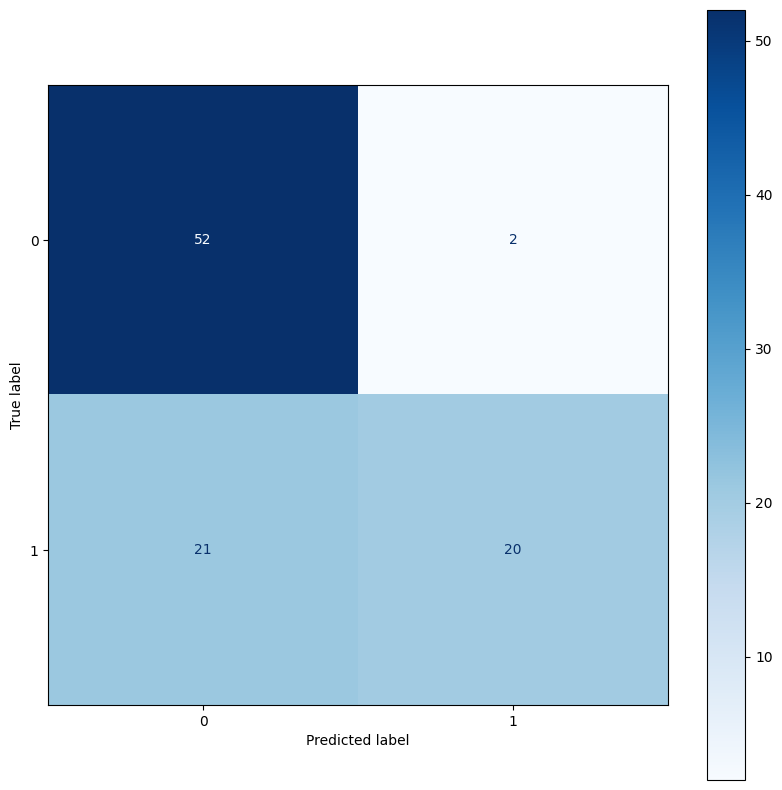

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

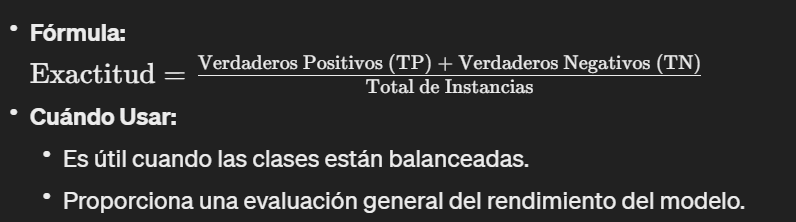

In [ ]:
from sklearn.metrics import accuracy_score


acc1=accuracy_score(y_test,y_pred)
acc1

0.7578947368421053

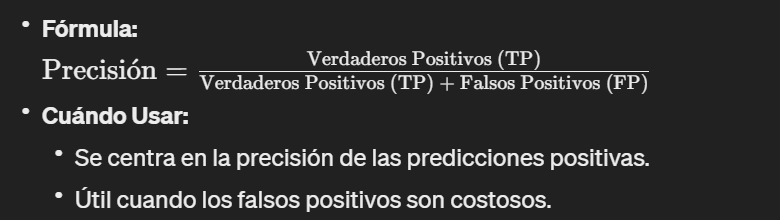

In [ ]:
from sklearn.metrics import precision_score

pr1=precision_score(y_test, y_pred)
pr1

0.9090909090909091

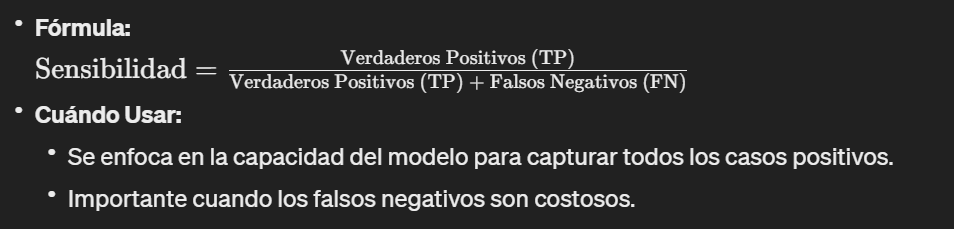

In [ ]:
from sklearn.metrics import recall_score

re1=recall_score(y_test, y_pred)
re1

0.4878048780487805

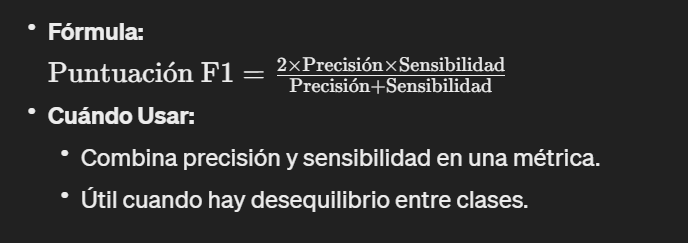

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.6349206349206349

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred)) #explicacion abajo

              precision    recall  f1-score   support

           0       0.71      0.96      0.82        54
           1       0.91      0.49      0.63        41

    accuracy                           0.76        95
   macro avg       0.81      0.73      0.73        95
weighted avg       0.80      0.76      0.74        95



**classification_report**

En metricas anteriores vimos resultados para una sola etiqueta, esta tabla es mas completa.

COMPONENTES

- Macro avg (Media de Clases): Es el promedio de las métricas de precisión, recall y F1-Score para cada clase.

- Weighted avg (Media Ponderada): Es el promedio de las métricas de precisión, recall y F1-Score para cada clase, teniendo en cuenta el número de ejemplos para cada clase.

- Support: cantidad de observaciones en calculo

- Accuracy: solo 1 porque involucra todos los TP, FP, TN y FN

- recall y precision: ver ejemplo que sigue

- f1 score: siguiendo formula y teniendo en cuenta recall y precision para cada clase

**Ejemplo calculo recall y precision para cada clase:**

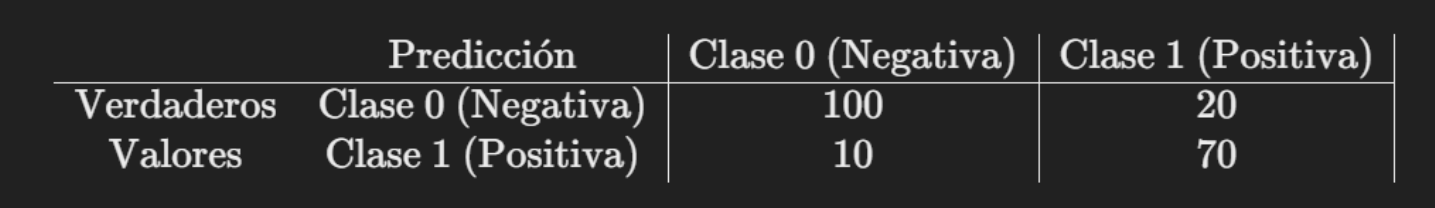

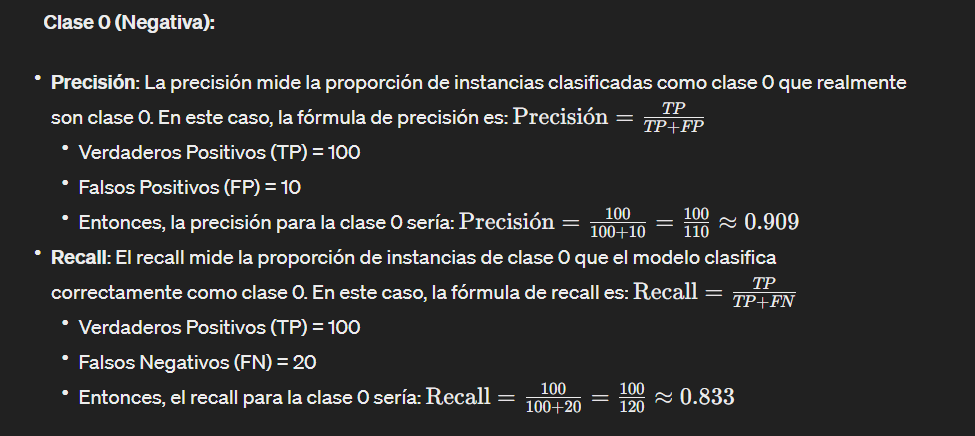

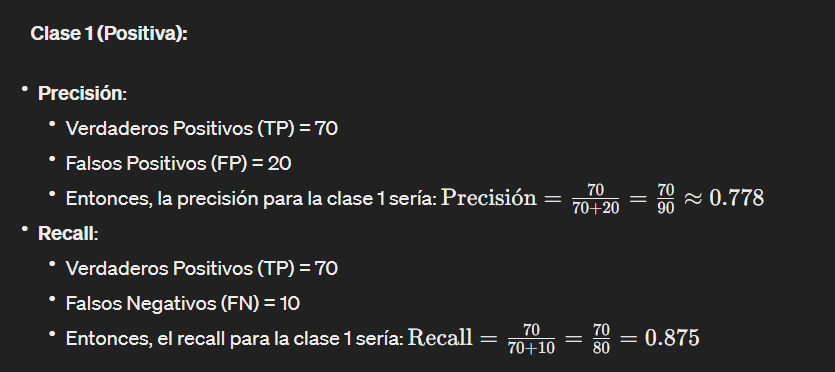

#Metodos de ensamble

Los métodos de ensamble son técnicas en el campo del aprendizaje automático que combinan múltiples modelos de predicción para mejorar el rendimiento general del sistema. En lugar de confiar en un solo modelo, los métodos de ensamble aprovechan la sabiduría colectiva de múltiples modelos para hacer predicciones más precisas y robustas.

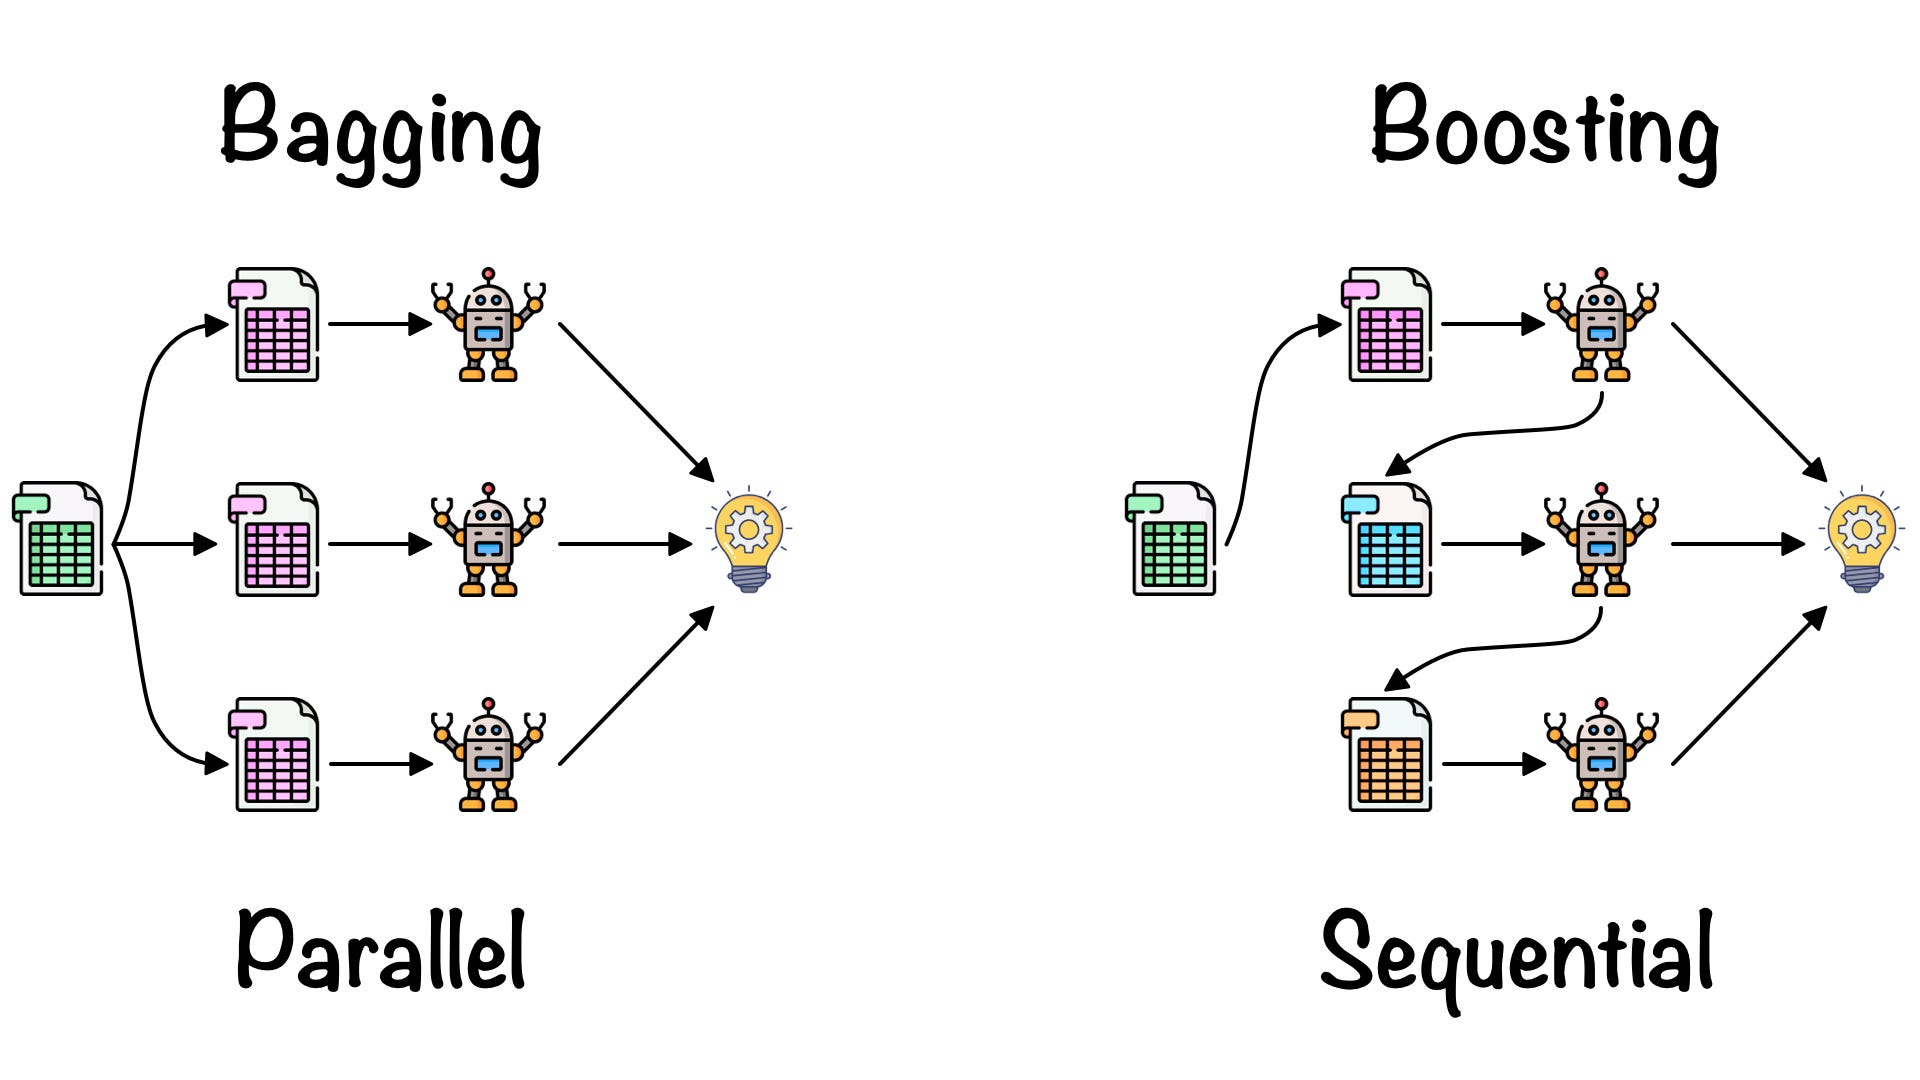

* **Bagging (Bootstrap Aggregating):**
Implica la construcción de múltiples modelos de manera independiente y luego combinar sus resultados para hacer una predicción final. Cada modelo se entrena en un subconjunto aleatorio de los datos de entrenamiento (muestreo con reemplazo). Después, las predicciones de estos modelos se combinan, a menudo promediando o votando, para producir una predicción final más robusta.

* **Boosting**: construye una secuencia de modelos de manera secuencial, donde cada nuevo modelo se enfoca en corregir los errores de los modelos anteriores. Los modelos débiles (por lo general, clasificadores débiles) se combinan para formar un modelo fuerte. Durante el entrenamiento, se da más peso a las instancias mal clasificadas, lo que permite que los modelos subsiguientes se concentren en corregir esas instancias.

## Bagging: Random Forest

Random Forest es un algoritmo de aprendizaje automático que construye múltiples árboles de decisión y combina sus predicciones para obtener un resultado más robusto. Cada árbol se entrena con diferentes subconjuntos de datos y características, lo que reduce el sobreajuste y mejora la generalización. Es eficaz tanto para clasificación como para regresión, y es conocido por su capacidad para manejar conjuntos de datos complejos y producir modelos precisos.

En resumen, Random Forest funciona para clasificación de la siguiente manera:

1. **Muestreo Aleatorio:**
   - Selecciona aleatoriamente diferentes subconjuntos de datos (con reemplazo) para entrenar varios árboles de decisión.

2. **Características Aleatorias:**
   - En cada división de un árbol, considera solo un subconjunto aleatorio de las características, lo que introduce aleatoriedad y reduce la correlación entre los árboles.

3. **Votación Mayoritaria:**
   - Cada árbol realiza una predicción y la clase más común es seleccionada por votación para la predicción final.

4. **Mejora de Generalización:**
   - La combinación de múltiples árboles y la aleatoriedad reduce el sobreajuste, mejora la generalización y proporciona un modelo robusto para la clasificación.

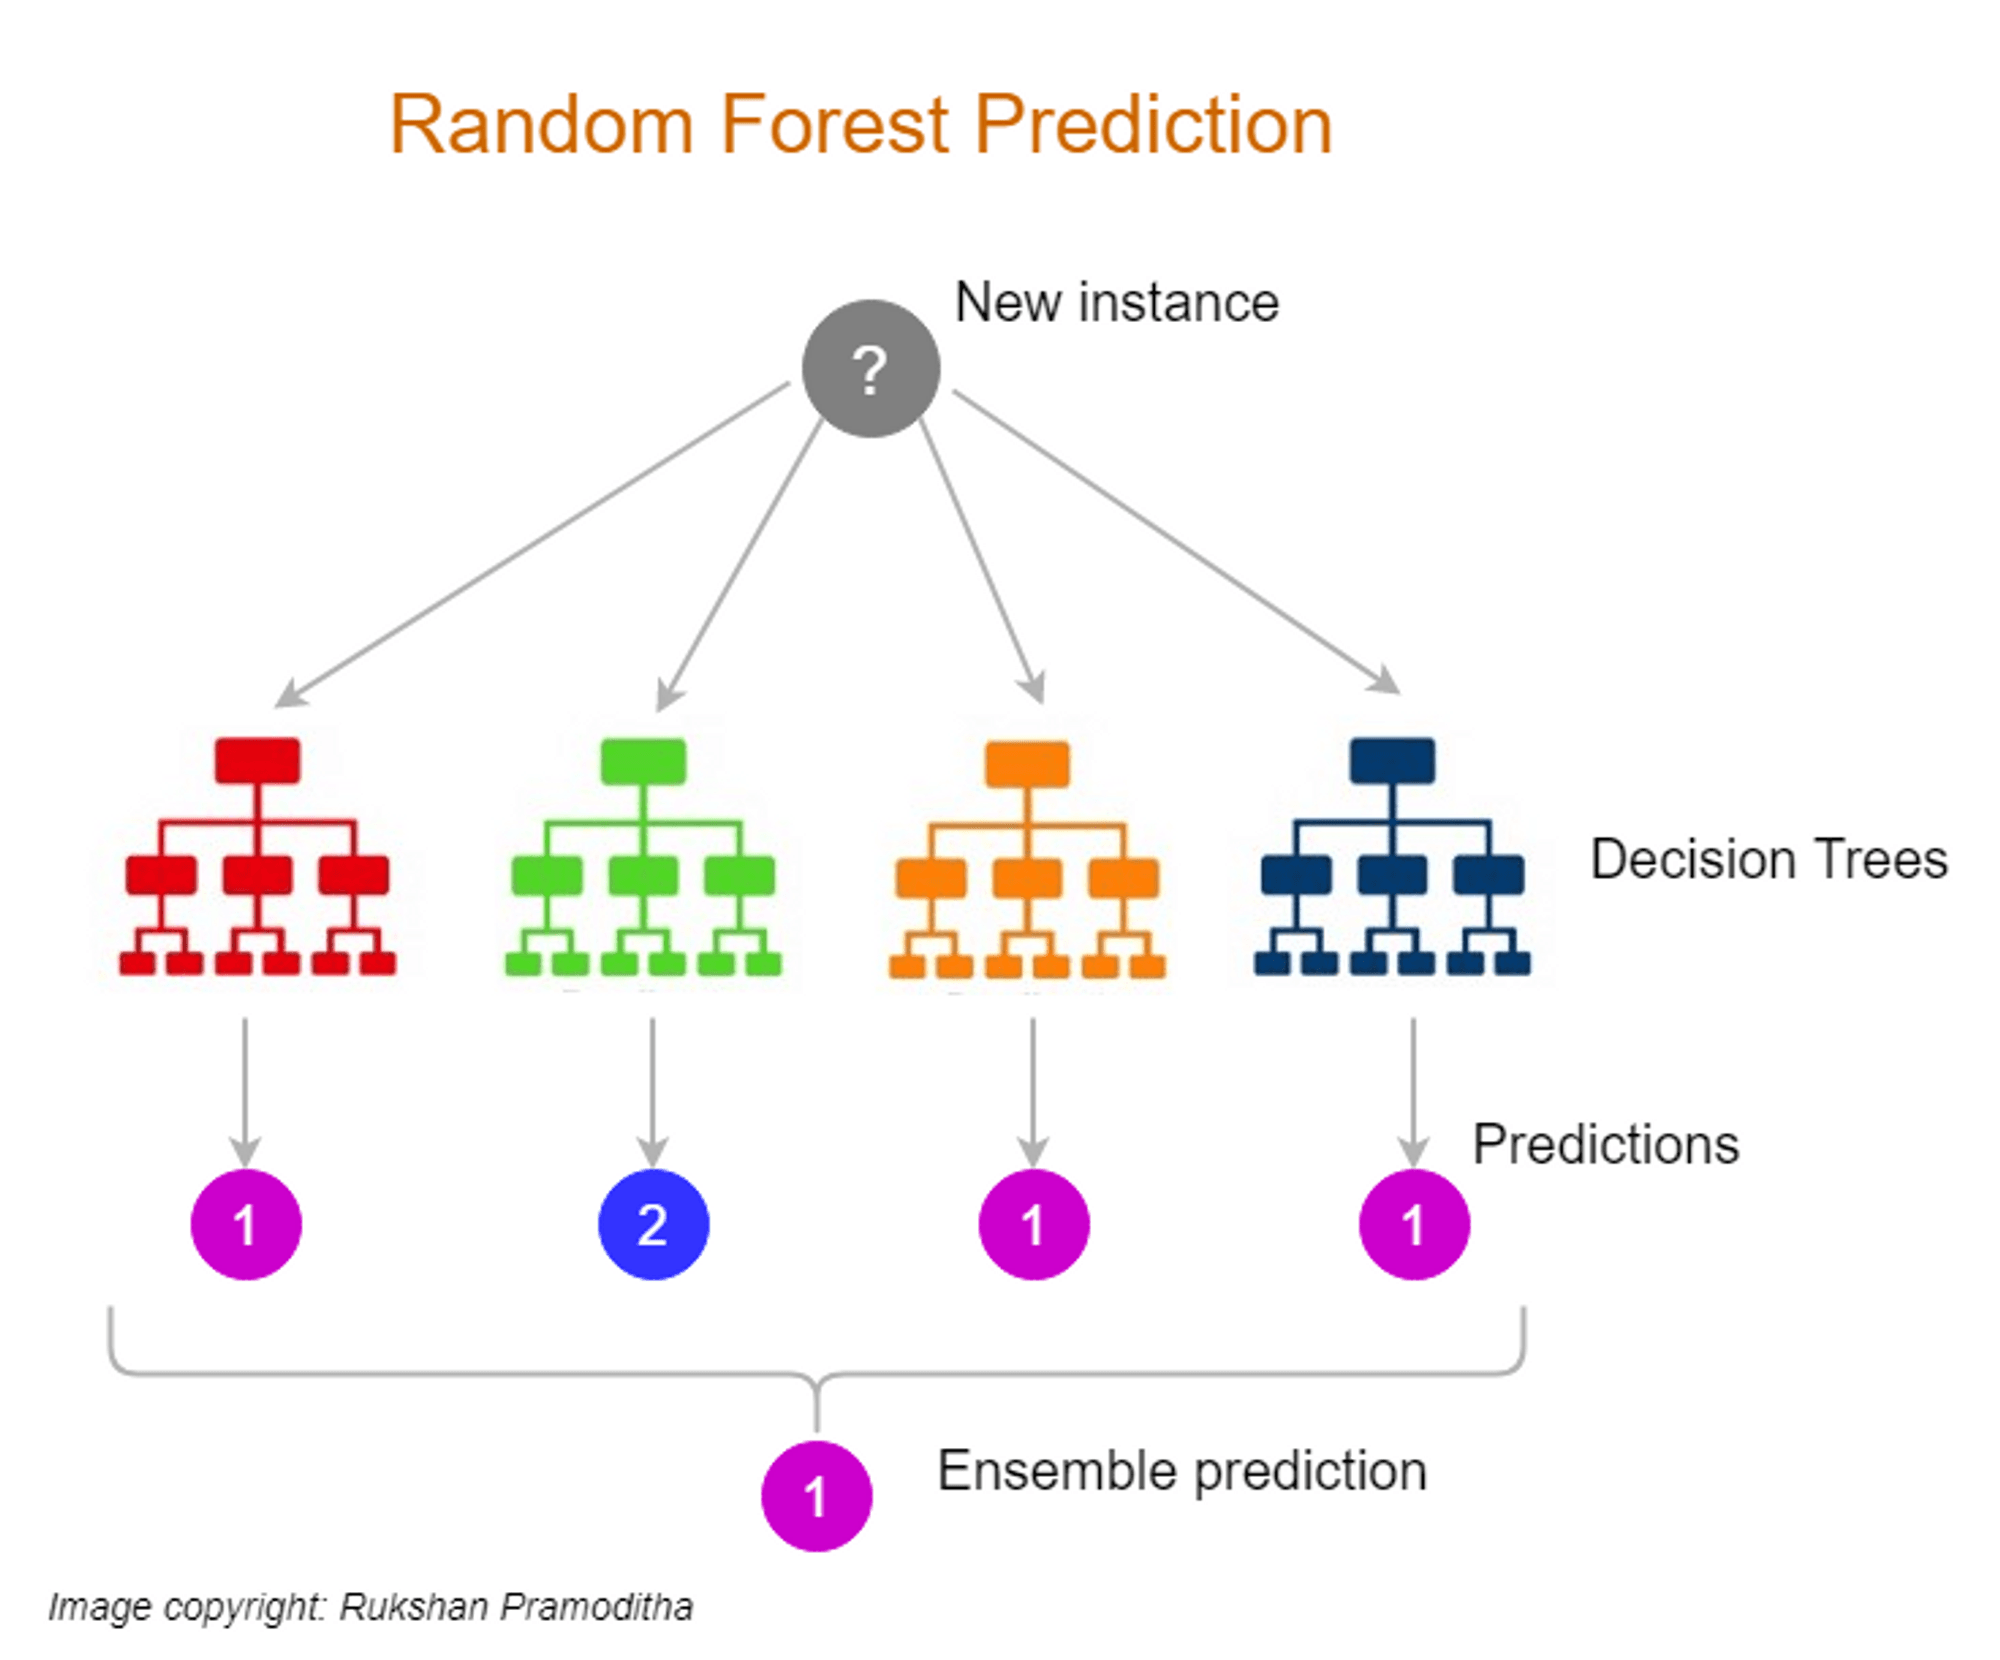

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Creamos un random forest!
model = RandomForestClassifier(random_state=42,
                               n_estimators=500, #cantidad de arboles que se van a construir
                               min_samples_split=5, #número mínimo de muestras requeridas para dividir un nodo interno
                               max_depth=5, #niveles de cada arbol

                               class_weight="balanced" #se puede usar para targets desbalanceados
                               )
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=500, random_state=42)

In [ ]:
y_pred2 = model.predict(X_test) #Prediccion en Test

In [ ]:
acc2=accuracy_score(y_test,y_pred2)
acc2

0.7684210526315789

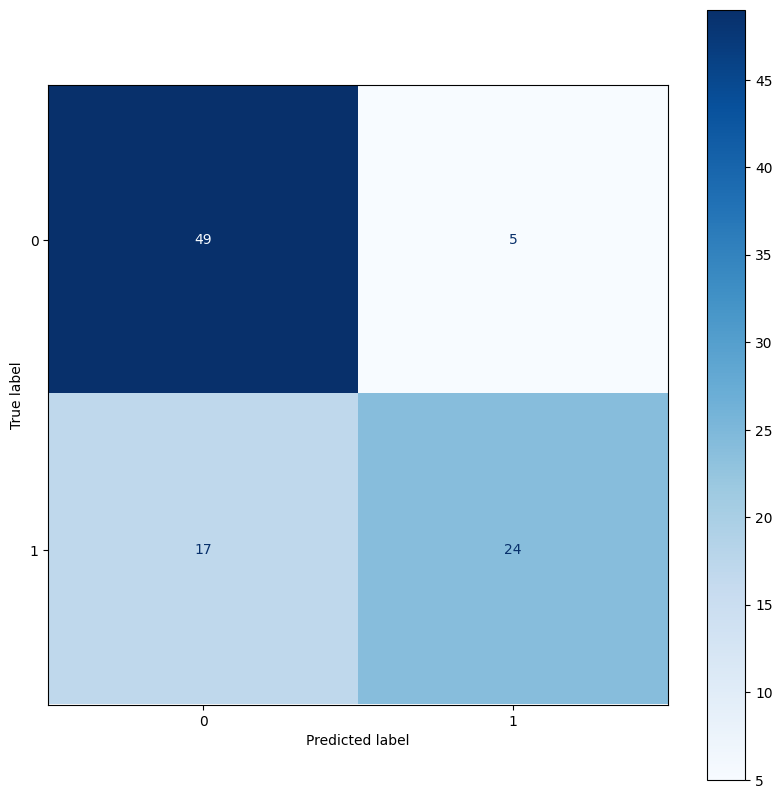

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

cm = confusion_matrix(y_test, y_pred2, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

In [ ]:
pr2=precision_score(y_test, y_pred2)
pr2

0.8275862068965517

In [ ]:
re2=recall_score(y_test, y_pred2)
re2

0.5853658536585366

In [ ]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82        54
           1       0.83      0.59      0.69        41

    accuracy                           0.77        95
   macro avg       0.79      0.75      0.75        95
weighted avg       0.78      0.77      0.76        95



## Boosting: XGBoost (Extreme Gradient Boosting)

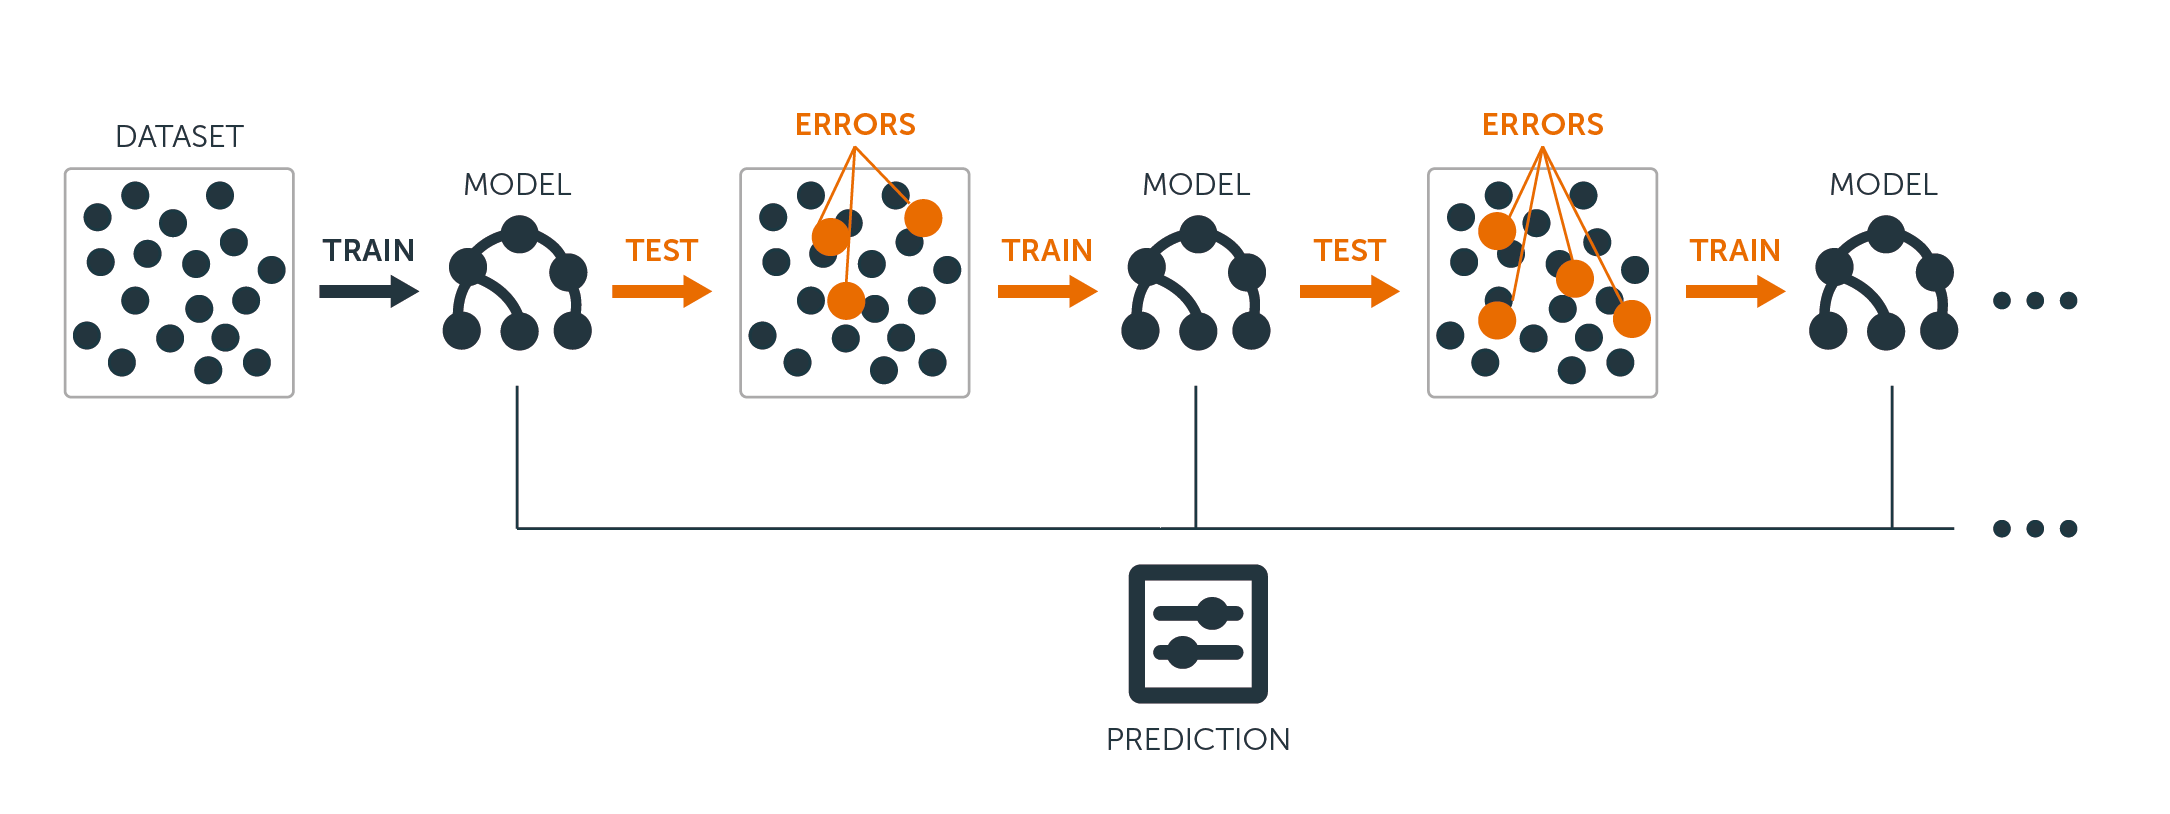

En resumen, XGBoost opera mediante el método de Gradient Boosting, que se desarrolla en las siguientes etapas:

* **Construcción Gradual de Modelos**: Comienza con un modelo simple y lo mejora gradualmente. Cada nuevo modelo se enfoca en corregir los errores del modelo anterior, ajustando sus predicciones para que estén más cerca de los valores reales.

* **Optimización de Gradiente Descendente**: Utiliza el método de optimización de gradiente descendente para minimizar una función de pérdida. Imagina que estás en una montaña y quieres llegar al fondo lo más rápido posible. El método de optimización de gradiente descendente te dice cómo moverte: simplemente caminas hacia abajo en la dirección más empinada. De la misma manera, en XGBoost, ajustamos nuestro modelo de tal manera que la predicción sea lo más cercana posible a la verdad. Lo hacemos moviéndonos en la dirección que reduce nuestros errores, como si estuviéramos caminando cuesta abajo hacia una solución mejor y más precisa.

* **Regularización y Control de Sobreajuste** : Implementa técnicas de regularización para evitar el sobreajuste, penalizando modelos demasiado complejos. El modelo podría aprender demasiado de nuestros datos de entrenamiento y no entender realmente cómo predecir nuevos datos. Para evitar eso, utilizamos técnicas de regularización, que básicamente nos hacen más cuidadosos al aprender de los ejemplos. Penalizamos nuestro modelo si se vuelve demasiado complejo, lo que nos ayuda a evitar que se vuelva demasiado especializado en los datos de entrenamiento y a hacer predicciones más precisas en general.

* **Combina Múltiples Modelos**: XGBoost combina los modelos construidos en cada etapa de Boosting, asignando un peso a cada uno según su contribución a la predicción final. Esta combinación ponderada produce un modelo más robusto y preciso.

En conjunto, XGBoost es una herramienta poderosa y versátil en el aprendizaje automático, conocida por su eficiencia, precisión y capacidad para manejar una amplia gama de problemas de modelado predictivo.

In [ ]:
from xgboost import XGBClassifier

# Paso 1: Instanciar el modelo
xgb_model = XGBClassifier()

# Paso 2: Ajustar el modelo a los datos de entrenamiento
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred3 = xgb_model.predict(X_test) #Prediccion en Test

In [ ]:
acc3=accuracy_score(y_test,y_pred3)
acc3

0.7578947368421053

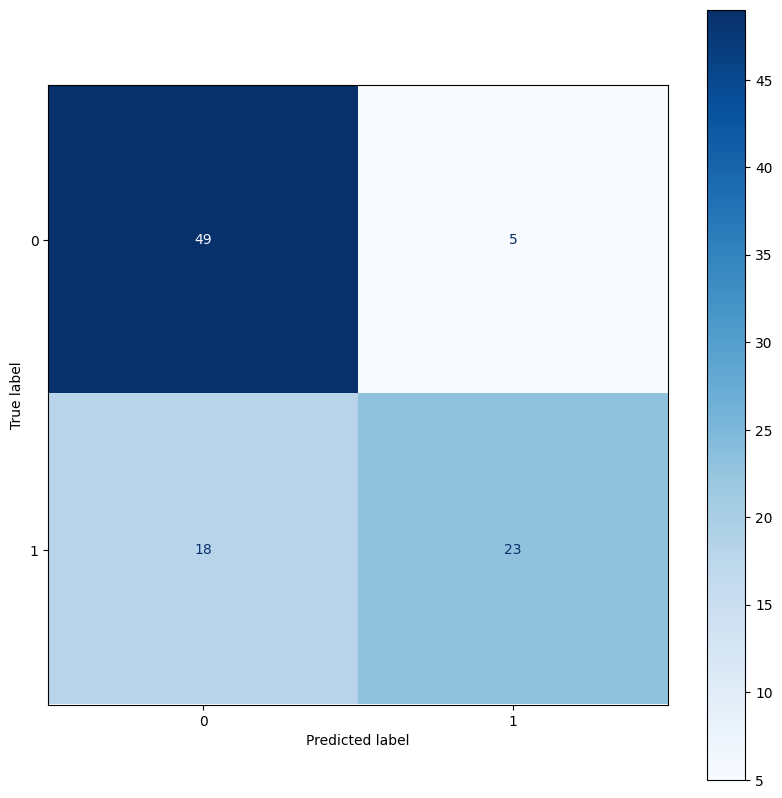

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

cm = confusion_matrix(y_test, y_pred3, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

In [ ]:
pr3=precision_score(y_test, y_pred3)
pr3

0.8214285714285714

In [ ]:
re3=recall_score(y_test, y_pred3)
re3

0.5609756097560976

In [ ]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81        54
           1       0.82      0.56      0.67        41

    accuracy                           0.76        95
   macro avg       0.78      0.73      0.74        95
weighted avg       0.77      0.76      0.75        95



**Comparacion de metricas**

In [ ]:
data = {
    'Modelo': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc1, acc2, acc3],
    'Precision [clase 1]': [pr1, pr2, pr3],
    'Recall [clase 1]': [re1, re2, re3]
}

df = pd.DataFrame(data)

# Encontrar los mejores puntajes por métrica
best_accuracy = df['Accuracy'].max()
best_precision = df['Precision [clase 1]'].max()
best_recall = df['Recall [clase 1]'].max()

def highlight_best_score(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Aplicar estilo al DataFrame
df_style = df.style.apply(highlight_best_score, subset=['Accuracy', 'Precision [clase 1]', 'Recall [clase 1]'])

df_style

,Modelo,Accuracy,Precision [clase 1],Recall [clase 1]
0,Decision Tree,0.757895,0.909091,0.487805
1,Random Forest,0.768421,0.827586,0.585366
2,XGBoost,0.757895,0.821429,0.560976
